In [41]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear.

In [42]:
path= r'C:\Users\jphil\OneDrive\Documents\CareerFoundry Data Analytics\Data Immersion\Achievement 6'

In [43]:
df=pd.read_csv(os.path.join(path, 'Data', 'Prepared data', 'crimes_derived.csv'), index_col=False)

In [44]:
df.head()

,Unnamed: 0.1,Unnamed: 0,incident_id,offense_id,offense_code,offense_code_extension,offense_type_id,offense_type_name,offense_category_id,first_occurrence_date,...,North America FB,Percent Living in Poverty,Percent Families in Poverty,GlobalID,Shape__Area,Shape__Length,danger_score_x,danger_score_y,danger_score,Danger Category
0,0,0,2.022749e+08,2.020000e+14,2999,0,criminal-mischief-other,Criminal mischief - other,public-disorder,2/12/2022 22:45,...,0,0.0,0.0,578ee93f-c666-4afb-a5da-464a0e1ce408,17995417.42,17705.43233,0.125999,0.125999,0.125999,Low danger
1,1,1,2.020529e+09,2.020000e+15,2999,0,criminal-mischief-other,Criminal mischief - other,public-disorder,9/1/2020 15:30,...,0,18.4,16.9,e08a87f1-5d62-4f3c-9c82-fe2177912601,43089441.09,27352.42330,0.153698,0.153698,0.153698,Low danger
2,2,2,2.019905e+06,2.020000e+12,2999,0,criminal-mischief-other,Criminal mischief - other,public-disorder,12/31/2018 21:30,...,0,18.4,16.9,e08a87f1-5d62-4f3c-9c82-fe2177912601,43089441.09,27352.42330,0.153698,0.153698,0.153698,Low danger
3,3,3,2.022261e+09,2.020000e+15,2999,0,criminal-mischief-other,Criminal mischief - other,public-disorder,5/24/2022 21:10,...,0,18.4,16.9,e08a87f1-5d62-4f3c-9c82-fe2177912601,43089441.09,27352.42330,0.153698,0.153698,0.153698,Low danger
4,4,4,2.022432e+09,2.020000e+15,2999,0,criminal-mischief-other,Criminal mischief - other,public-disorder,8/22/2022 22:45,...,0,18.4,16.9,e08a87f1-5d62-4f3c-9c82-fe2177912601,43089441.09,27352.42330,0.153698,0.153698,0.153698,Low danger


# Subsetting and plotting the line graph

In [45]:
#subsetting the df
sub=df[['first_occurrence_date']]

In [ ]:
#I chose just the date column as I want to see just how the frequency of crimes behaved over time.

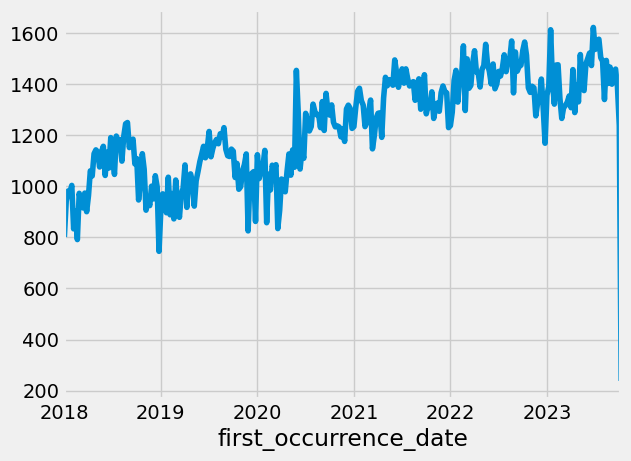

In [6]:
# Convert 'first_occurrence_date' to datetime
sub['first_occurrence_date'] = pd.to_datetime(sub['first_occurrence_date'])

# Group by week
weekly_counts = sub.groupby(pd.Grouper(key='first_occurrence_date', freq='W')).size()

# Plot the results
line=weekly_counts.plot(kind='line')

In [29]:
line.figure.savefig(os.path.join(path, 'Analysis', 'Visualizations', 'crime_frequency_timeseries.png'))

# Decomposition

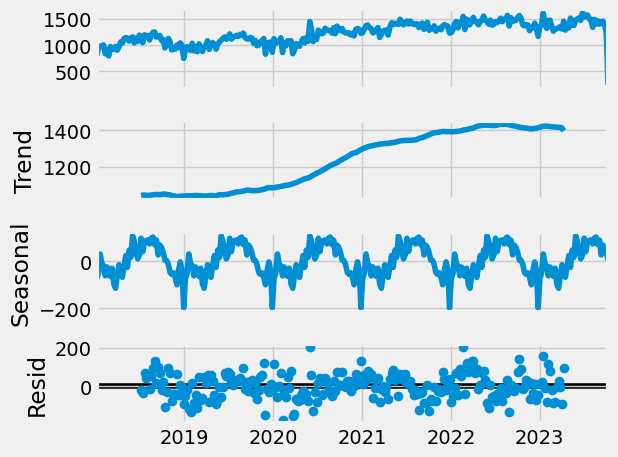

In [7]:
# Resample the data to weekly frequency
subs = sub.resample('W', on='first_occurrence_date').size()

# Ensure the index has a frequency
subs.index.freq = 'W'

# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(subs, model='additive', period=52)

# Plotting the decomposition
decomp=decomposition.plot()

In [ ]:
#Firstly, the 'trend' component shows us a gradually upward trajectory over time. This was apparent in the original chart as well.
#It looks like there is seasonality to the crimes as well, with natural peaks and valleys occurring eveyr year
#It looks like crime peaks in the summer/warmer months, and troughs in the winter/colder months
#The resid shows us that yes, there is a fair amount of noise, aka random fluctuations that occur- something I would expect to see with a phenomenon as multivariate as city crime.

In [36]:
decomp.figure.savefig(os.path.join(path, 'Analysis', 'Visualizations', 'crimes_decomposed.png'))

# Checking for stationarity

In [8]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(sub['first_occurrence_date'])

Dickey-Fuller Stationarity test:
Test Statistic                     -0.297476
p-value                             0.925861
Number of Lags Used                94.000000
Number of Observations Used    370396.000000
Critical Value (1%)                -3.430368
Critical Value (5%)                -2.861548
Critical Value (10%)               -2.566774
dtype: float64


In [ ]:
#as expected, the data is NOT stationary. 
#this was readily apparent as indicated by the gradual upward trend.
#since the test statistic, -.297, is bigger than all three critical values, we cannot reject the null hypothesis that this chart is non-stationary.

# Attempting to stationarize the data

In [9]:
data_diff = subs - subs.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [10]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

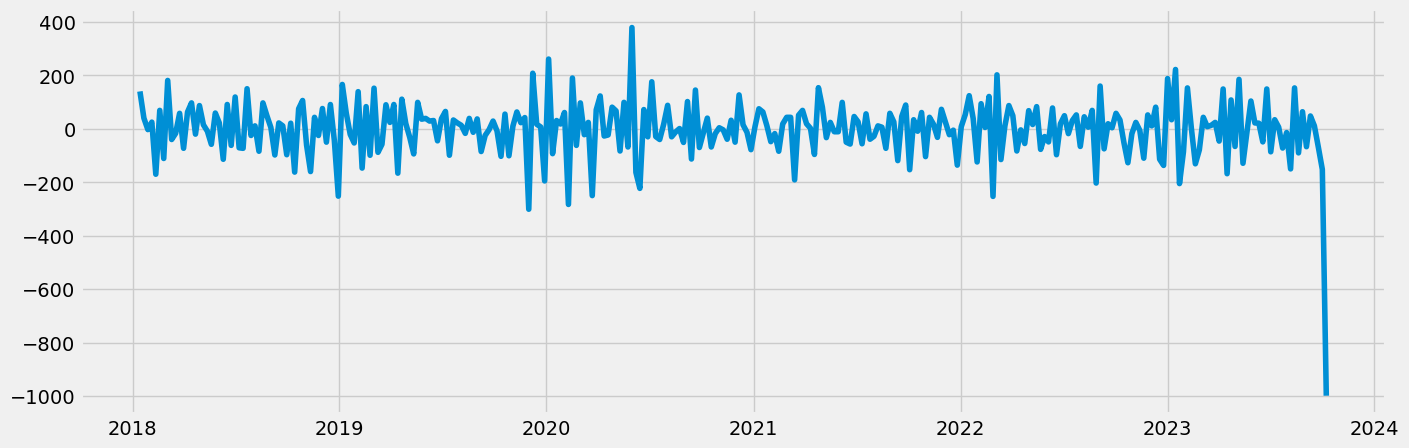

In [11]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [ ]:
#okay this looks stationary now!

In [47]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.197729e+01
p-value                        3.775736e-22
Number of Lags Used            2.000000e+00
Number of Observations Used    2.970000e+02
Critical Value (1%)           -3.452561e+00
Critical Value (5%)           -2.871321e+00
Critical Value (10%)          -2.571982e+00
dtype: float64


In [ ]:
#okay i think the last observation is skweing the graph- I am going to remove it as it is not an accurate representation.

<Axes: xlabel='first_occurrence_date'>

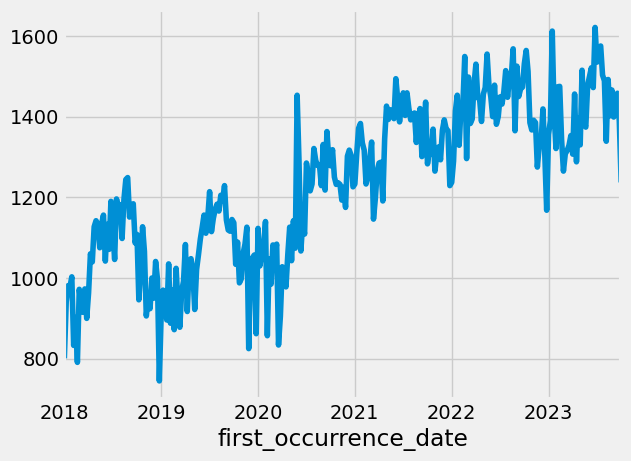

In [12]:
# Drop the last observation
sub_cleaned = subs.iloc[:-1]

# Plot the cleaned data
sub_cleaned.plot(kind='line')

In [13]:
data_diff = sub_cleaned - sub_cleaned.shift(1)

In [14]:
data_diff.dropna(inplace = True)

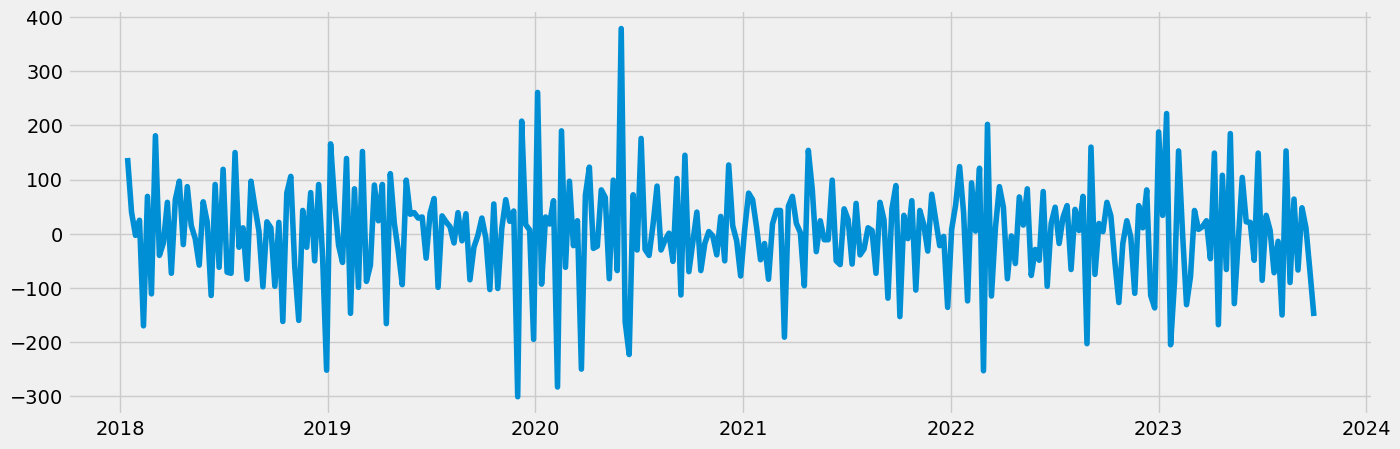

In [15]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [52]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.705259e+01
p-value                        8.050465e-30
Number of Lags Used            2.000000e+00
Number of Observations Used    2.960000e+02
Critical Value (1%)           -3.452637e+00
Critical Value (5%)           -2.871354e+00
Critical Value (10%)          -2.571999e+00
dtype: float64


In [ ]:
#even after removal of the last observation, I still cannot reject the null hypothesis.

In [16]:
data_diffs = data_diff - data_diff.shift(1)

In [17]:
data_diffs.dropna(inplace = True)

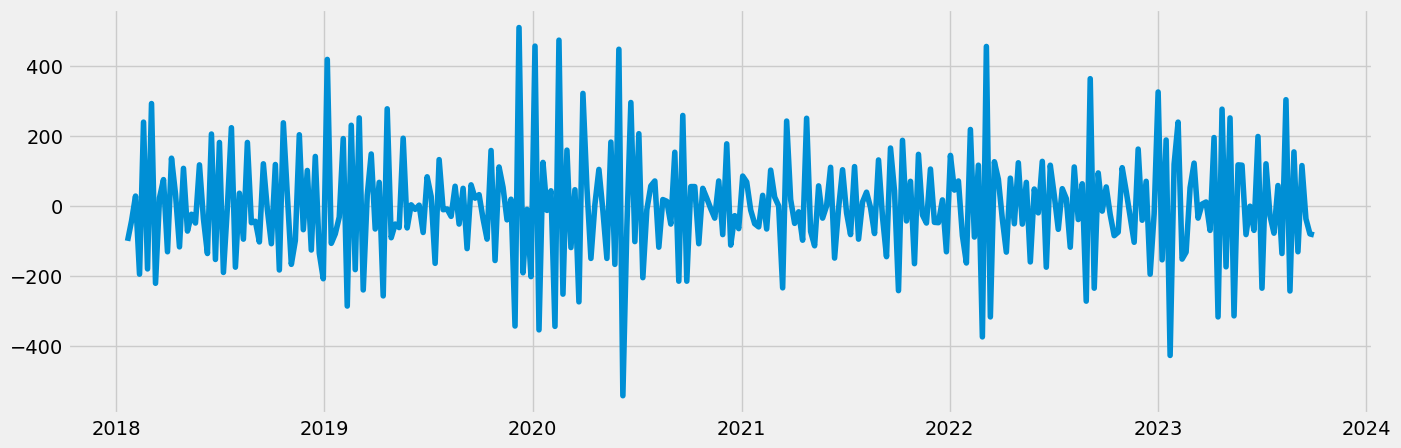

In [18]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diffs)

In [56]:
dickey_fuller(data_diffs)

Dickey-Fuller Stationarity test:
Test Statistic                -8.704289e+00
p-value                        3.736436e-14
Number of Lags Used            1.200000e+01
Number of Observations Used    2.850000e+02
Critical Value (1%)           -3.453505e+00
Critical Value (5%)           -2.871735e+00
Critical Value (10%)          -2.572202e+00
dtype: float64


In [ ]:
#the test statistic is less than the 5% critical value, so now we can reject the null hypothesis!

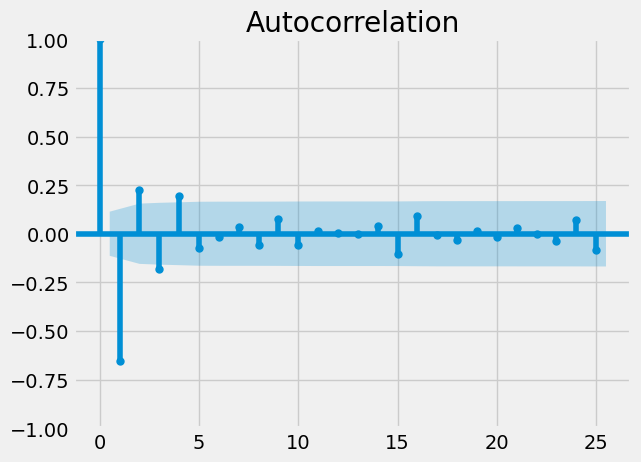

In [19]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_diffs)
plt.show()

In [ ]:
#this shows me that the data isn't as correlated with each other- although there is still some autocorrelation present
#this tells me the stationarity isn't as strong as it could be

In [20]:
#let's try one more round of differencing
data_difff = data_diffs - data_diffs.shift(1)

In [21]:
data_difff.dropna(inplace = True)

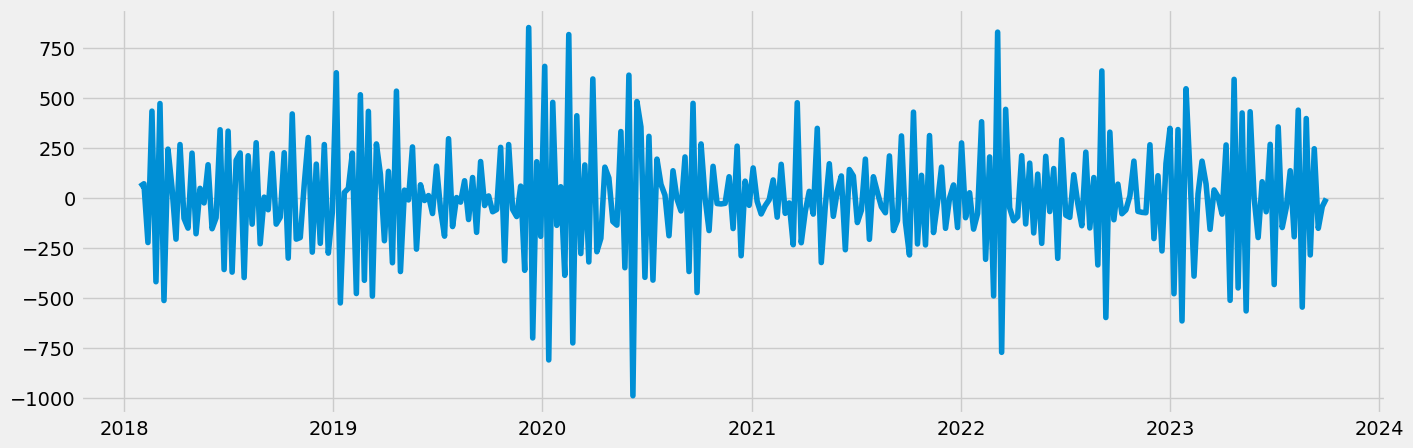

In [22]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_difff)

In [61]:
dickey_fuller(data_difff)

Dickey-Fuller Stationarity test:
Test Statistic                -9.617232e+00
p-value                        1.747189e-16
Number of Lags Used            1.500000e+01
Number of Observations Used    2.810000e+02
Critical Value (1%)           -3.453838e+00
Critical Value (5%)           -2.871881e+00
Critical Value (10%)          -2.572280e+00
dtype: float64


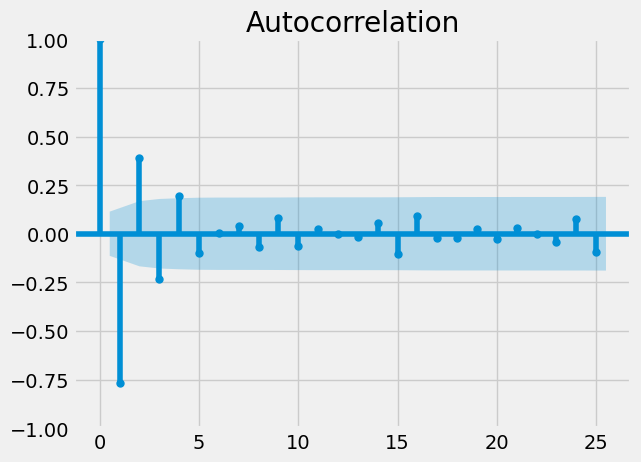

In [23]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_difff)
plt.show()

In [ ]:
#hmm- it didn't change the autocorrelation plot. perhaps the addition of moving average could help with this?
#since this autocorrelation looks slightly worse than the previous one, I am going to stick the previous one, meaning I differenced twice.

# Bonus task!

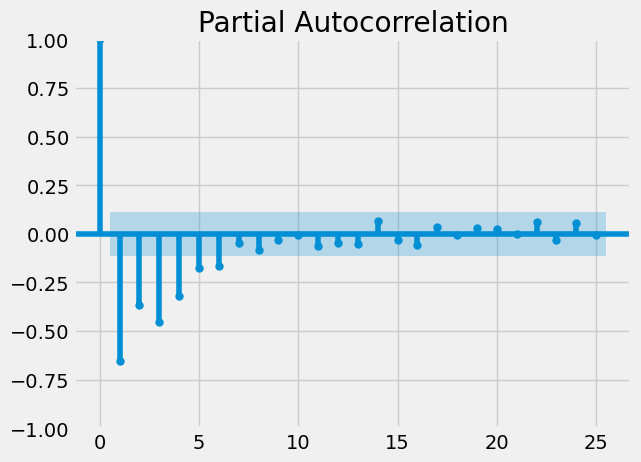

<Figure size 4500x4500 with 0 Axes>

In [24]:
# Plot partial autocorrelations to determine parameter p

plot_pacf(data_diffs)
plt.figure(figsize=(15,15), dpi=300)
plt.show()

In [ ]:
#this figure shows us that there are 5 highly positive bars, so I will start with p=5

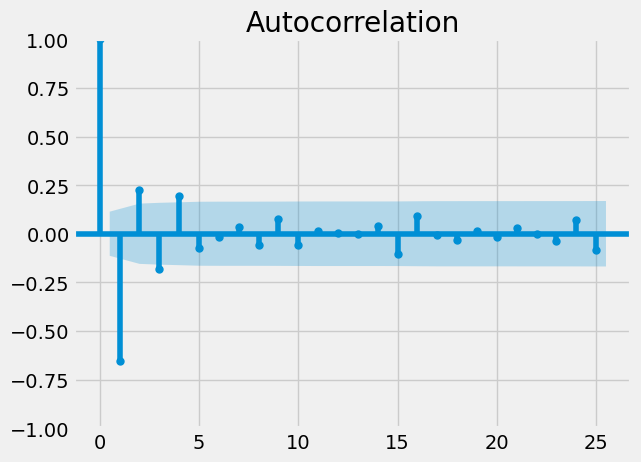

<Figure size 1500x500 with 0 Axes>

In [25]:
# Plot autocorrelations to determine parameter q

plot_acf(data_diffs)
plt.figure(figsize=(15,5), dpi=100)
plt.show()

In [ ]:
#there are 5 bars outside the blue border, but since it is advisable to start with fewer terms, I will start with q=3.

# Splitting the data

In [46]:
# Step 1: Ensure 'first_occurrence_date' is in datetime format
sub['first_occurrence_date'] = pd.to_datetime(sub['first_occurrence_date'])

# Step 2: Set 'first_occurrence_date' as the index
sub.set_index('first_occurrence_date', inplace=True)

# Step 3: Aggregate by week using resample
weekly_counts = sub.resample('W').size()

# Convert the result to a DataFrame
weekly_counts = pd.DataFrame(weekly_counts, columns=['weekly_counts'])

# Step 4: Apply differencing
weekly_counts['diff1'] = weekly_counts['weekly_counts'].diff().dropna()
weekly_counts['diff2'] = weekly_counts['diff1'].diff().dropna()

# Drop NA values resulting from differencing
diff_data = weekly_counts[['diff2']].dropna()

# Step 5: Split the data into training and test sets
train_size = int(len(diff_data) * 0.8)
train, test = diff_data.iloc[:train_size], diff_data.iloc[train_size:]

# Confirm the structure and column names
print(train.head())


                       diff2
first_occurrence_date       
2018-01-21            -100.0
2018-01-28             -43.0
2018-02-04              28.0
2018-02-11            -195.0
2018-02-18             239.0


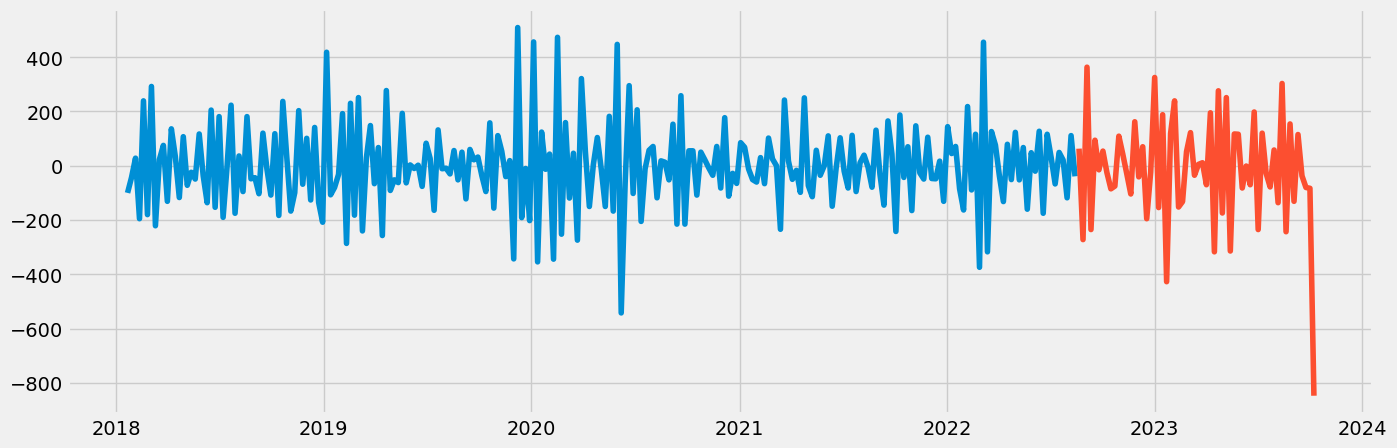

In [48]:
# Plot both sets in order to see the split

plt.figure(figsize=(15,5), dpi=100)
plt.plot(train)
plt.plot(test)

In [ ]:
#I want to remove the last observation in the test set as it is not an accurate representation.

<Axes: xlabel='first_occurrence_date'>

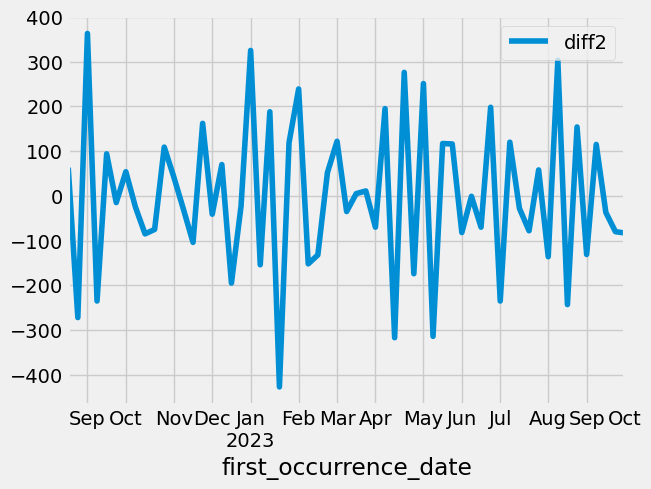

In [49]:
# Drop the last observation
test_cleaned = test.iloc[:-1]

# Plot the cleaned data
test_cleaned.plot(kind='line')

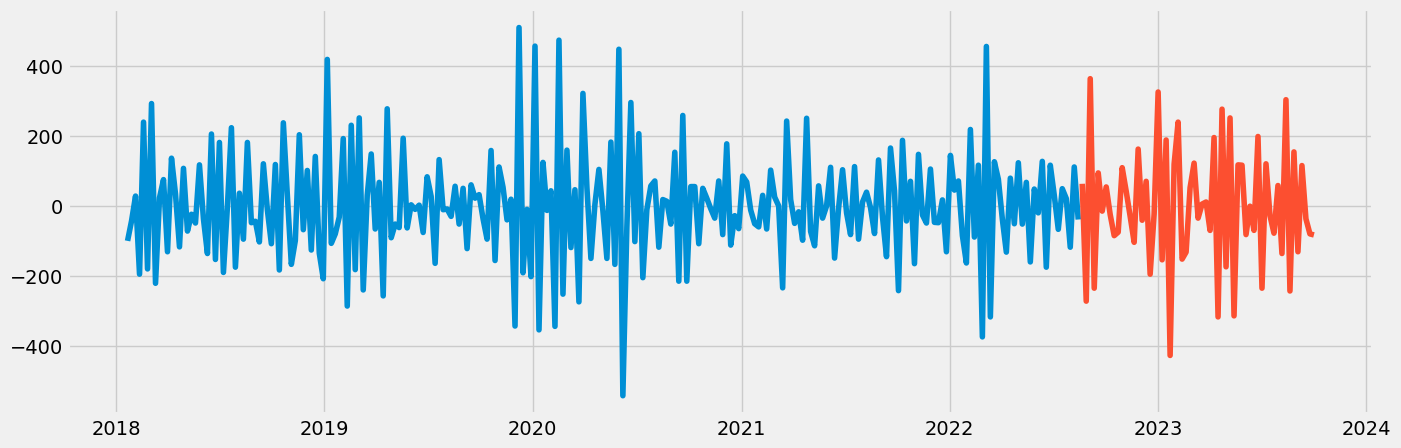

In [50]:
# Plot both sets in order to see the split

plt.figure(figsize=(15,5), dpi=100)
plt.plot(train)
plt.plot(test_cleaned)

# Running and fitting the model

In [51]:
from statsmodels.tsa.api import ARIMA # Import the model you need

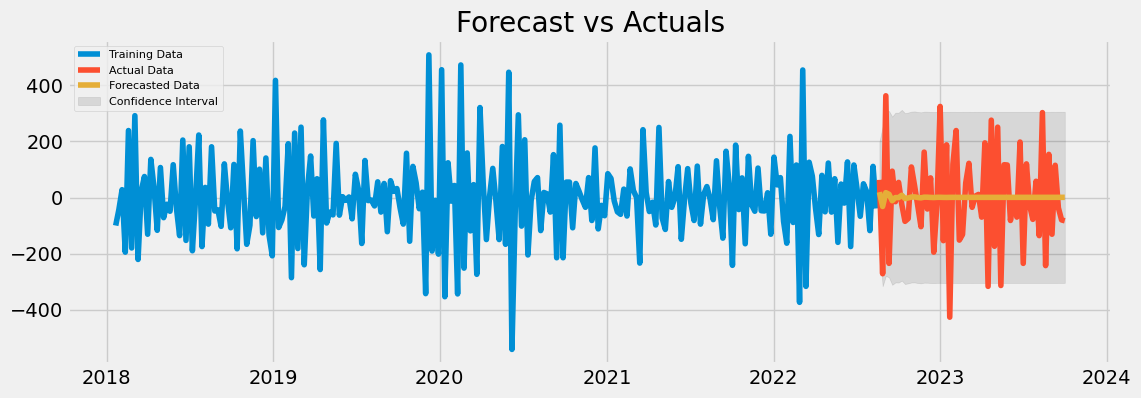

In [53]:
# Forecasting using ARIMA model
forecast_results = fitted.get_forecast(steps=len(test_cleaned))

# Get the forecasted mean
fc_series = forecast_results.predicted_mean

# Get confidence intervals
conf_int = forecast_results.conf_int(alpha=0.05)

# Create lower and upper bounds of confidence intervals
lower_series = conf_int.iloc[:, 0]
upper_series = conf_int.iloc[:, 1]

# Plotting the results
plt.figure(figsize=(12, 4), dpi=100)
plt.plot(train, label='Training Data')
plt.plot(test_cleaned, label='Actual Data')
plt.plot(fc_series, label='Forecasted Data')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.1, label='Confidence Interval')  # Adjusted alpha for better visibility
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


                               SARIMAX Results                                
Dep. Variable:                  diff2   No. Observations:                  239
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -1382.456
Date:                Thu, 15 Aug 2024   AIC                           2780.911
Time:                        11:01:48   BIC                           2808.689
Sample:                    01-21-2018   HQIC                          2792.106
                         - 08-14-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6061      0.072    -22.371      0.000      -1.747      -1.465
ar.L2         -0.9949      0.126     -7.925      0.000      -1.241      -0.749
ar.L3         -0.6814      0.112     -6.083      0.0

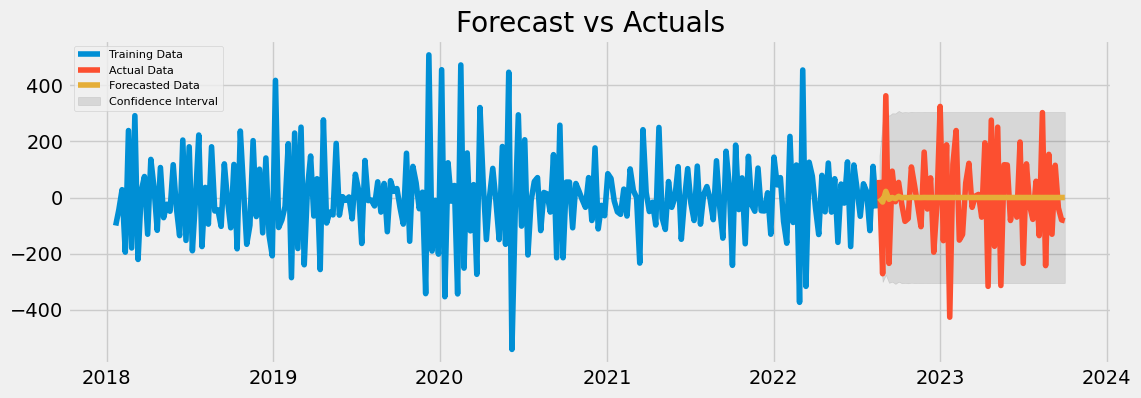

In [56]:
# Try a simpler ARIMA model
model = ARIMA(train, order=(4, 1, 3))  # Adjust p, d, q based on your data analysis
fitted = model.fit()
print(fitted.summary())

# Forecasting and plotting as before
forecast_results = fitted.get_forecast(steps=len(test_cleaned))
fc_series = forecast_results.predicted_mean
conf_int = forecast_results.conf_int(alpha=0.05)
lower_series = conf_int.iloc[:, 0]
upper_series = conf_int.iloc[:, 1]

plt.figure(figsize=(12, 4), dpi=100)
plt.plot(train, label='Training Data')
plt.plot(test_cleaned, label='Actual Data')
plt.plot(fc_series, label='Forecasted Data')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.1, label='Confidence Interval')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [ ]:
#the forecasted line is flat, suggesting that the model isn't capturing the fluctuations in the data, and thus isn't a good fit. 
#perhaps trying a SARIMA model would be more accurate.

# Using ChatGPT to try a SARIMA model

                                      SARIMAX Results                                       
Dep. Variable:                                diff2   No. Observations:                  239
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 52)   Log Likelihood               -1141.944
Date:                              Thu, 15 Aug 2024   AIC                           2297.888
Time:                                      11:04:13   BIC                           2320.468
Sample:                                  01-21-2018   HQIC                          2307.038
                                       - 08-14-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5701      0.151     -3.772      0.000      -0.866      -0.274
ar.L2         -0.29

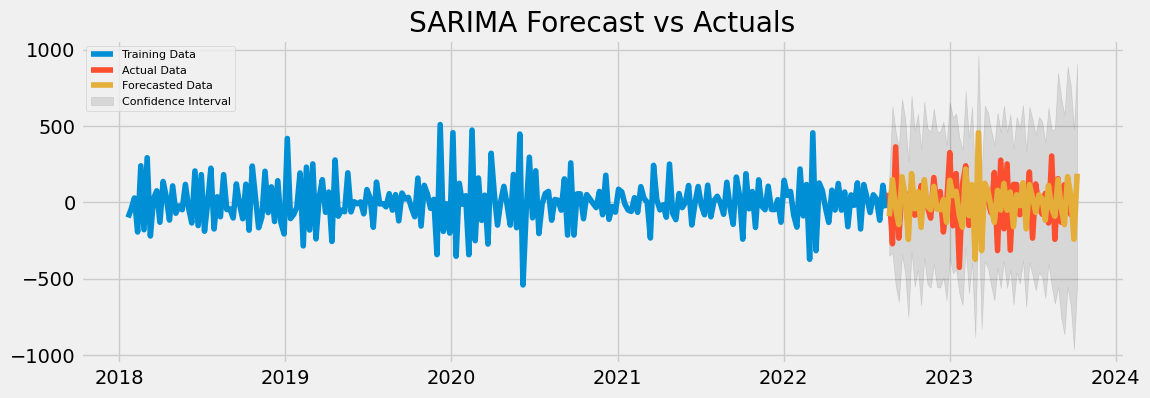

In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Step 1: Define the model parameters
p, d, q = 2, 1, 2  # Non-seasonal parameters
P, D, Q, m = 1, 1, 1, 52  # Seasonal parameters (assuming weekly data with yearly seasonality)

# Step 2: Fit the SARIMA model
sarima_model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, m))
sarima_fitted = sarima_model.fit(disp=False)
print(sarima_fitted.summary())

# Step 3: Forecast
sarima_forecast = sarima_fitted.get_forecast(steps=len(test))
fc_series = sarima_forecast.predicted_mean
conf_int = sarima_forecast.conf_int(alpha=0.05)

# Step 4: Create lower and upper bounds of confidence intervals
lower_series = conf_int.iloc[:, 0]
upper_series = conf_int.iloc[:, 1]

# Step 5: Plot the results
plt.figure(figsize=(12, 4), dpi=100)
plt.plot(train, label='Training Data')
plt.plot(test_cleaned, label='Actual Data')
plt.plot(fc_series, label='Forecasted Data')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.1, label='Confidence Interval')
plt.title('SARIMA Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


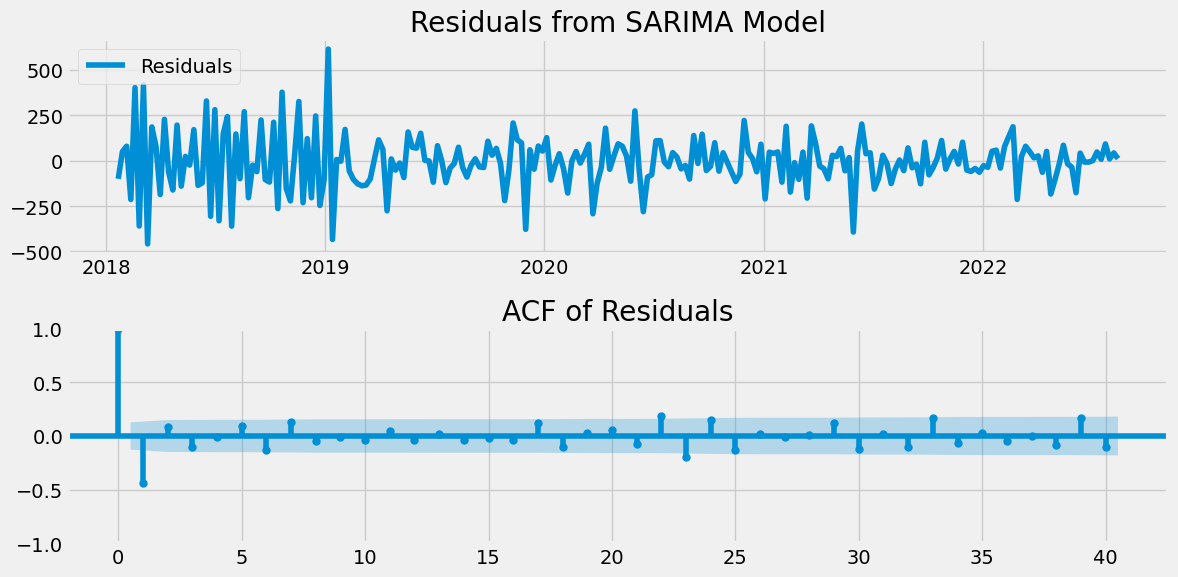

      lb_stat     lb_pvalue
10  62.676957  1.124939e-09


In [58]:
# Step 1: Extract the residuals
residuals = sarima_fitted.resid

# Step 2: Plot the residuals
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(residuals, label='Residuals')
plt.title('Residuals from SARIMA Model')
plt.legend(loc='upper left')

# Step 3: Plot ACF of residuals
plt.subplot(212)
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=plt.gca())
plt.title('ACF of Residuals')
plt.tight_layout()
plt.show()

# Step 4: Perform Ljung-Box test
ljung_box_results = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box_results)


In [ ]:
#this shows me that the SARIMA model is decent, but there are still some significant autocorrelations present, suggesting the model can be improved.

                                      SARIMAX Results                                       
Dep. Variable:                                diff2   No. Observations:                  239
Model:             SARIMAX(3, 1, 3)x(1, 1, [1], 52)   Log Likelihood               -1110.413
Date:                              Thu, 15 Aug 2024   AIC                           2238.827
Time:                                      11:14:07   BIC                           2267.859
Sample:                                  01-21-2018   HQIC                          2250.592
                                       - 08-14-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5930     36.441     -0.044      0.965     -73.017      69.831
ar.L2         -0.83

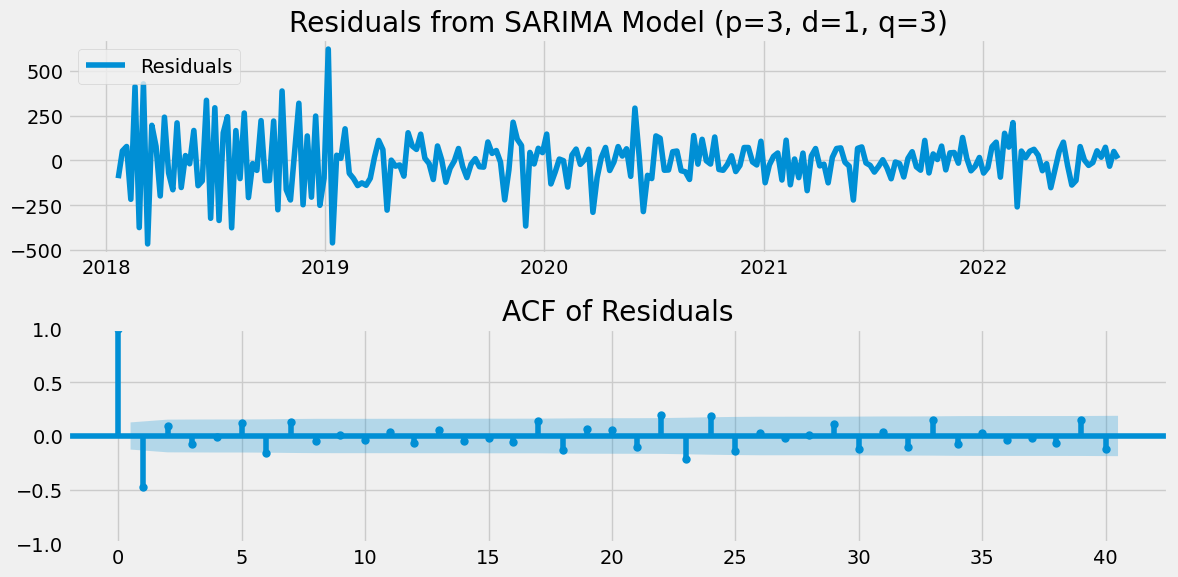

    lb_stat     lb_pvalue
10  73.3536  9.941486e-12


In [59]:
# Trying a higher order for AR and MA components
p, d, q = 3, 1, 3
P, D, Q, m = 1, 1, 1, 52

# Fit the SARIMA model
sarima_model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, m))
sarima_fitted = sarima_model.fit(disp=False)
print(sarima_fitted.summary())

# Evaluate the residuals as before
residuals = sarima_fitted.resid
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(residuals, label='Residuals')
plt.title('Residuals from SARIMA Model (p=3, d=1, q=3)')
plt.legend(loc='upper left')
plt.subplot(212)
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=plt.gca())
plt.title('ACF of Residuals')
plt.tight_layout()
plt.show()

# Ljung-Box Test
ljung_box_results = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box_results)


                                     SARIMAX Results                                      
Dep. Variable:                              diff2   No. Observations:                  239
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 52)   Log Likelihood               -1144.612
Date:                            Thu, 15 Aug 2024   AIC                           2307.225
Time:                                    11:15:12   BIC                           2336.257
Sample:                                01-21-2018   HQIC                          2318.990
                                     - 08-14-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5768      0.161     -3.582      0.000      -0.892      -0.261
ar.L2          0.0182      0.150   

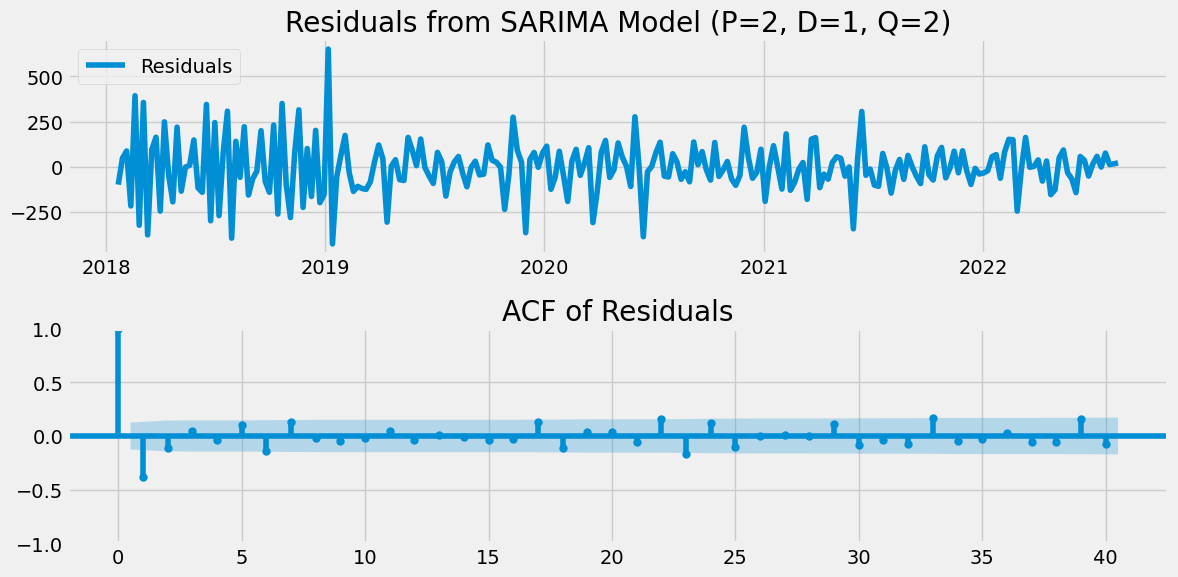

      lb_stat     lb_pvalue
10  51.441803  1.447338e-07


In [60]:
# Trying higher seasonal AR and MA orders
p, d, q = 2, 1, 2
P, D, Q, m = 2, 1, 2, 52

# Fit the SARIMA model
sarima_model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, m))
sarima_fitted = sarima_model.fit(disp=False)
print(sarima_fitted.summary())

# Evaluate the residuals as before
residuals = sarima_fitted.resid
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(residuals, label='Residuals')
plt.title('Residuals from SARIMA Model (P=2, D=1, Q=2)')
plt.legend(loc='upper left')
plt.subplot(212)
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=plt.gca())
plt.title('ACF of Residuals')
plt.tight_layout()
plt.show()

# Ljung-Box Test
ljung_box_results = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box_results)


In [ ]:
#okay, so those last two iterations didn't do much to improve the model. I think that is enough practice.
#My model could still be improve, but at least it is better than before.